# Fast Approximate Matrix Profiles with SCRUMP

In 
[this paper](https://www.cs.ucr.edu/~eamonn/SCRIMP_ICDM_camera_ready_updated.pdf), a new approach called "SCRIMP++", which computes a matrix profile in an incremental fashion, is presented. When only an approximate matrix profile is needed, the this algorithm uses certain properties of the matrix profile calculation to greatly reduce the total computational time and, in this tutorial, we'll demonstrate how this approach may be sufficient for your applications.

`stumpy` implements this approach for both self-joins and AB-joins in the `stumpy.scrump` function and it allows for the matrix profile to be easily refined when a higher resolution output is desired.

## Getting started

First, let us import some packages we will use for data loading, analyzing, and plotting.

In [1]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import urllib
import ssl
import io
import os

The python function below is going to be used throughout this example to automatically resize and create the plots that are displayed using the Matplotlib python plotting package.

In [2]:
def change_plot_size(width, height, plt):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.rcParams["figure.figsize"] = fig_size
    plt.rcParams['xtick.direction'] = 'out'
    
change_plot_size(20, 6, plt)

## Load the Steamgen Dataset

This data was generated using fuzzy models applied to mimic a steam generator at the Abbott Power Plant in Champaign, IL. The data feature that we are interested in is the output steam flow telemetry that has units of kg/s and the data is "sampled" every three seconds with a total of 9,600 datapoints.


In [3]:
colnames = ['drum pressure',
            'excess oxygen',
            'water level',
            'steam flow'
           ]

context = ssl.SSLContext()  # Ignore SSL certificate verification for simplicity
url = 'https://www.cs.ucr.edu/~eamonn/iSAX/steamgen.dat'
raw_bytes = urllib.request.urlopen(url, context=context).read()
data = io.BytesIO(raw_bytes)
steam_df = pd.read_csv(data, header=None, sep="\s+")
steam_df.columns = colnames
steam_df.head()

,drum pressure,excess oxygen,water level,steam flow
0,320.08239,2.506774,0.032701,9.302970
1,321.71099,2.545908,0.284799,9.662621
2,320.91331,2.360562,0.203652,10.990955
3,325.00252,0.027054,0.326187,12.430107
4,326.65276,0.285649,0.753776,13.681666


## Visualizing the Steamgen Dataset

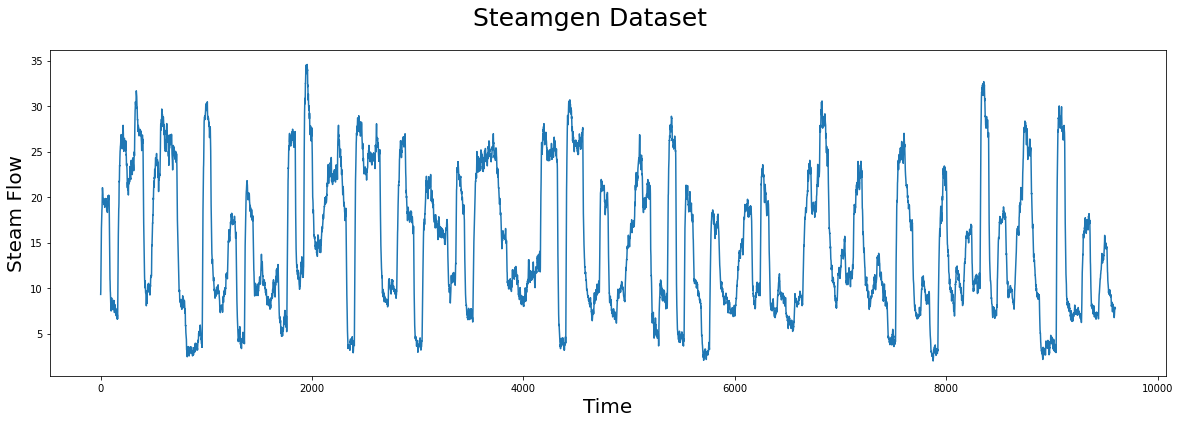

In [4]:
plt.suptitle('Steamgen Dataset', fontsize='25')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Steam Flow', fontsize='20')
plt.plot(steam_df['steam flow'].values)

## Computing the True Matrix Profile

Now, as a benchmark to compare against, we will compute the full matrix profile using the `stumpy.stump` function along with a window wize of `m=640`.

In [5]:
m = 640
mp = stumpy.stump(steam_df['steam flow'], m)
true_P = mp[:, 0]

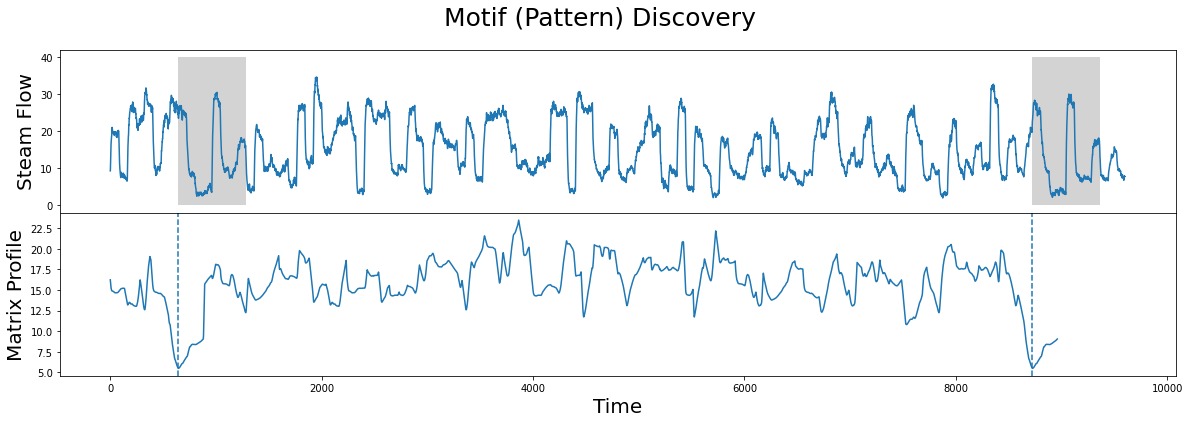

In [6]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='25')

axs[0].plot(steam_df['steam flow'].values)
axs[0].set_ylabel('Steam Flow', fontsize='20')
rect = Rectangle((643, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((8724, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=643, linestyle="dashed")
axs[1].axvline(x=8724, linestyle="dashed")
axs[1].plot(true_P)

The global minima of the matrix profile, symbolised with the dashed lines, are the indices of the top motif, i.e. the two sub-sequences which are most similar to each other. When using the matrix profile, in many application these are the two most important subsequences, and we will see how we can use `stumpy.scrump` to quickly come up with an approximate matrix profile in a fraction of the time.

Additionally, we will use the helper function below to visually compare the true matrix profile (`true_P` - computed with `stumpy.stump`) with the approximated matrix profile (`approx_P` - computed with `stumpy.scrump`).

In [7]:
def compare_approximation(true_P, approx_P):
    fig, ax = plt.subplots(gridspec_kw={'hspace': 0})

    ax.set_xlabel('Time', fontsize ='20')
    ax.axvline(x=643, linestyle="dashed")
    ax.axvline(x=8724, linestyle="dashed")
    ax.set_ylim((5, 28))
    ax.plot(approx_P, color='C1', label="Approximate Matrix Profile")
    ax.plot(true_P, label="True Matrix Profile")
    ax.legend()

## Computing an Approximate Matrix Profile Using SCRUMP

To calculate the full matrix profile, one has to compute the whole distance matrix (i.e., the pairwise distances between all pairs of subsequences). However, `stumpy.scrump` computes this distance matrix in a diagonal-wise fashion but only using a subset of all diagonals (and, therefore, only using a subset of all distances). How many pairwise distances along the diagonals you want to compute is controlled by the `percentage` argument. The more distance you compute, the better the approximation will be but this also implies a higher computational cost. Choosing a value of `1.0`, or 100% of all distances, produces the full exact matrix profile (equivalent to the output from `stumpy.stump`). It is important to note that even though less pairwise distances are being computed, no pairwise distance is being approximated. That is, you are always guaranteed that `approx_P >= true_P` when `percentage <= 1.0` and, at `percentage=1.0`, `approx_P == true_P` (i.e., it is exact).

Now, let's call `stumpy.scrump` and approximate the full matrix profile by computing only 1% of all distances (i.e., `percentage=0.01`):

In [8]:
approx = stumpy.scrump(steam_df['steam flow'], m, percentage=0.01, pre_scrump=False)

There are a couple of things to notice. First, we passed in a `pre_scrump` argument, a preprocessing step for `stumpy.scrump` that, when set to `True`, can greatly improve the approximation. For now, we turn off the preprocessing step for demonstration purporses and revisit it in the next section. Second, `stumpy.scrump` initializes and returns a `scrump` object and not the matrix profile directly and we will see why this is useful below. 

To retrieve the first approximation (i.e., a matrix profile computed from 1% of all distances), we simply call the `.update()` method:

In [9]:
approx.update()

And we can access the updated matrix profile and the matrix profile indices via the `.P_` and `.I_` attributes, respectively: 

In [10]:
approx_P = approx.P_

Please keep in mind that the approximate matrix profile is computed by randomly computing distances along a subset of diagonals. So, each time you initialize a new `scrump` object by calling `stumpy.scrump`, this will randomly shuffle the order that the distances are computed, which inevitably results in different approximate matrix profiles (except when `percentage=1.0`). Depending on your use case, to ensure reproducible results, you may consider setting random seed prior to calling `stumpy.scrump`:

```
seed = np.random.randint(100000)
np.random.seed(seed)
approx = stumpy.scrump(steam_df['steam flow'], m, percentage=0.01, pre_scrump=False)
```

Next, let's plot `approx_P` on top of the `true_P` to see how well they compare:

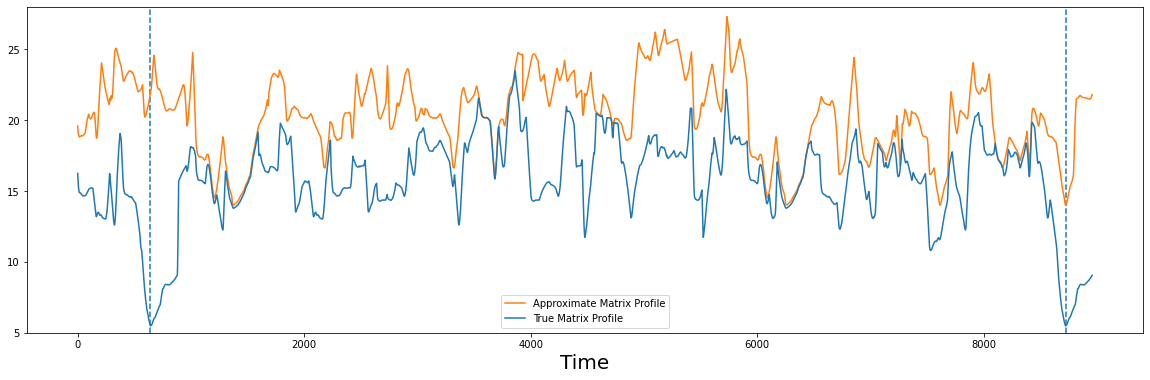

In [11]:
compare_approximation(true_P, approx_P)

We can see, that this approximation (in orange) is far from perfect but there are some similarities between the two. However, the lowest points in the approximation do not correspond to the true minima yet.

## Refining the distance profile

However, we can incrementally update and refine the approximation, by calling our generator again. Below, we call `next` nine more times (i.e., `10 * 0.01 = 0.10`) , so our new approximated matrix profile will be computed using roughly 10% of all pairwise distances in the full distance matrix.

In [12]:
for _ in range(9):
    approx.update()
    
approx_P = approx.P_

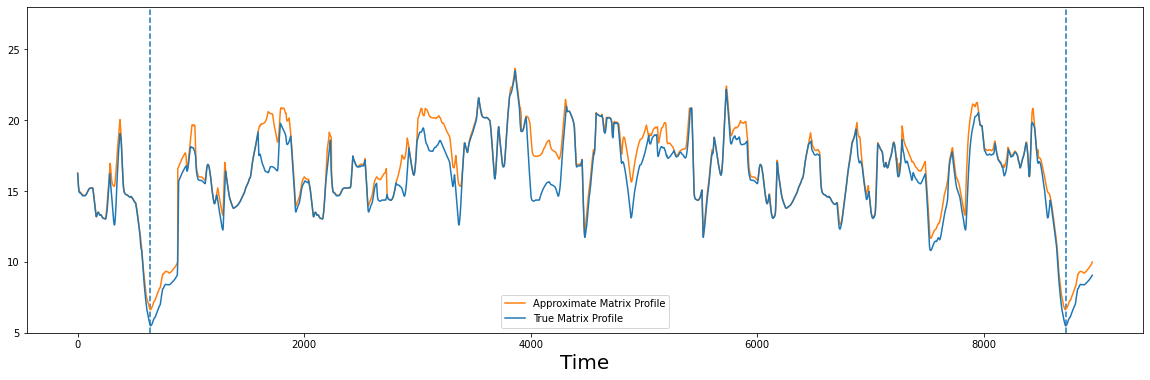

In [13]:
compare_approximation(true_P, approx_P)

Now, this result is much more convincing and it only required computing just 10% of all of the pairwise distances! We can see that the two profiles are very similar, in particular the important features like global minima are at almost equal, if not equal, positions. For most applications this is enough, as an offset of a few points usually does not matter and the number of distances that had to be calculated was reduced by a factor of ten! In fact, we can do even better this!

## The Power of Preprocessing

Until now, we only ran `stumpy.scrump` without the powerful "PRESCRIMP" preprocessing step. "PRESCRIMP" is an algorithm that preprocesses the time series data with complexity `O(n log(n) / s)`, where `n` is the number of points and `s` is called the sampling rate. `stumpy.stump` and `stumpy.scrump` (without PRESCRIMP) are both `O(n^2)` complexity so, in general, preprocessing is 'cheap'. PRESCRIMP already computes the distances of some pairwise distances and the sampling rate controls how many. Typically, a good value is `s=m/4`, the same size as the typical exclusion zone, and this value is used if you pass `None` to the `scrimp.scrump` function call.

Below we will approximate the matrix profile again with 1% of all diagonals but, this time, we'll enable preprocessing by setting `pre_scrimp=True`. Obviously, this will take a bit longer to compute, since a few more calculations have to be performed:

In [14]:
approx = stumpy.scrump(steam_df['steam flow'], m, percentage=0.01, pre_scrump=True, s=None)
approx.update()
approx_P = approx.P_

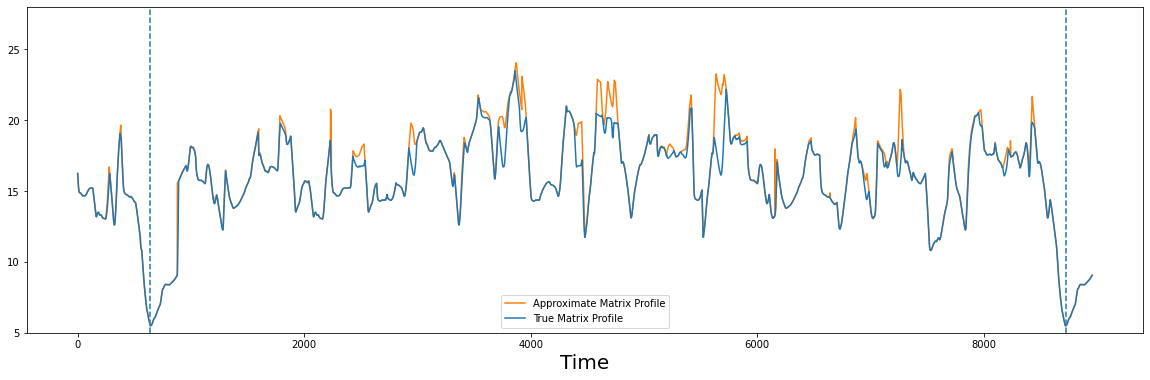

In [15]:
compare_approximation(true_P, approx_P)

However, one can see that in this example, with preprocessing followed by computing only 1% of the pairwise distances (i.e., calling `.update()` only once), the approximate matrix profile and the true matrix profile are nearly visually indistinguishable. With increasing time series length, the benefit of using preprocessing grows even further. Of course, depending on the size of the time series data that you need to analyze and the available computing resources at your disposal, it may be worth it to compute a higher percentage of distances to be certain that the approximation is converged.

## Summary

That's it! You have learned how to approximate the matrix profile using `stumpy.scrump` and hopefully can use the approximated matrix profile in your application.

## Resources

[Matrix Profile XI](https://www.cs.ucr.edu/~eamonn/SCRIMP_ICDM_camera_ready_updated.pdf)